In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from pathlib import Path

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# omd
import datetime
import importlib
import sys

sys.path.append('../../My-Code/')

import timetools as tt
import omdutils as omd

importlib.reload(tt)

print('timetools version: {}'.format(tt.__version__))
print('omdutils version: {}'.format(omd.__version__))
print('statsmodels version: {}'.format(sm.__version__))

timetools version: 10.09.2022
omdutils version: 8.6.2022
statsmodels version: 0.13.2


In [2]:
path = Path('/home/oliver/Documents/Data')

In [23]:
df = pd.read_csv('data/airpassengers.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [24]:
df['Month'] = pd.to_datetime(df.Month + '-01')
df['Month'] = df['Month'].dt.date
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [ ]:
omd.to_sqlite(df, 'air_passengers', str(path/'Datasets'))

In [38]:
from tqdm import tqdm

a=0

for i in tqdm(range(10000000)):
    a += 1


100%|██████████| 10000000/10000000 [00:01<00:00, 5246745.54it/s]


# Start Chapter 8  
### ARIMA (p,d,q)

In [4]:
path = Path('/home/oliver/Documents/Data')

In [5]:
df = omd.from_sqlite('select * from air_passengers', str(path/'Datasets'))
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


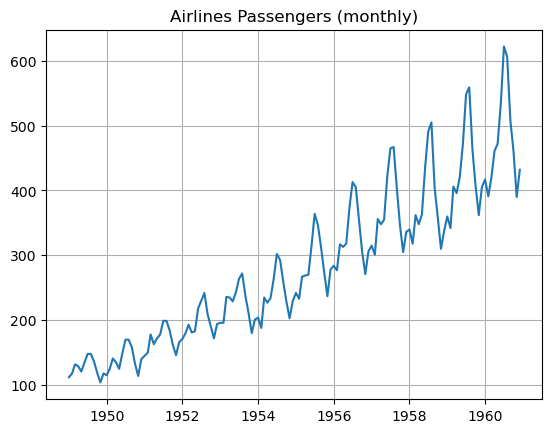

In [6]:
plt.plot(df['Passengers'])
plt.title('Airlines Passengers (monthly)')
plt.grid(True)

In [7]:
# stationary?
tt.adf_v2(df['Passengers'], diff=0)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=0

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

The time series is not stationary.


In [8]:
tt.adf_v2(df['Passengers'], diff=1)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=1

Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

The time series is not stationary.


In [9]:
tt.adf_v2(df['Passengers'], diff=2)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=2

Test Statistic                -1.638423e+01
p-value                        2.732892e-29
#Lags Used                     1.100000e+01
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64

The time series is stationary.


In [10]:
ps = range(0, 13, 1)
qs = range(0,13, 1)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 12

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [11]:
ARIMA_order_list

[(0, 0, 0, 0),
 (0, 1, 0, 0),
 (0, 2, 0, 0),
 (0, 3, 0, 0),
 (0, 4, 0, 0),
 (0, 5, 0, 0),
 (0, 6, 0, 0),
 (0, 7, 0, 0),
 (0, 8, 0, 0),
 (0, 9, 0, 0),
 (0, 10, 0, 0),
 (0, 11, 0, 0),
 (0, 12, 0, 0),
 (1, 0, 0, 0),
 (1, 1, 0, 0),
 (1, 2, 0, 0),
 (1, 3, 0, 0),
 (1, 4, 0, 0),
 (1, 5, 0, 0),
 (1, 6, 0, 0),
 (1, 7, 0, 0),
 (1, 8, 0, 0),
 (1, 9, 0, 0),
 (1, 10, 0, 0),
 (1, 11, 0, 0),
 (1, 12, 0, 0),
 (2, 0, 0, 0),
 (2, 1, 0, 0),
 (2, 2, 0, 0),
 (2, 3, 0, 0),
 (2, 4, 0, 0),
 (2, 5, 0, 0),
 (2, 6, 0, 0),
 (2, 7, 0, 0),
 (2, 8, 0, 0),
 (2, 9, 0, 0),
 (2, 10, 0, 0),
 (2, 11, 0, 0),
 (2, 12, 0, 0),
 (3, 0, 0, 0),
 (3, 1, 0, 0),
 (3, 2, 0, 0),
 (3, 3, 0, 0),
 (3, 4, 0, 0),
 (3, 5, 0, 0),
 (3, 6, 0, 0),
 (3, 7, 0, 0),
 (3, 8, 0, 0),
 (3, 9, 0, 0),
 (3, 10, 0, 0),
 (3, 11, 0, 0),
 (3, 12, 0, 0),
 (4, 0, 0, 0),
 (4, 1, 0, 0),
 (4, 2, 0, 0),
 (4, 3, 0, 0),
 (4, 4, 0, 0),
 (4, 5, 0, 0),
 (4, 6, 0, 0),
 (4, 7, 0, 0),
 (4, 8, 0, 0),
 (4, 9, 0, 0),
 (4, 10, 0, 0),
 (4, 11, 0, 0),
 (4, 12, 0, 0),
 (5, 0, 0,

In [12]:
df_train = df[:-12]

In [13]:
tt.optimize_SARIMA(df_train['Passengers'], ARIMA_order_list, d, D, s=12)

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.838103
1,"(11, 4, 0, 0)",1019.034751
2,"(11, 5, 0, 0)",1020.379289
3,"(12, 0, 0, 0)",1020.644888
4,"(11, 1, 0, 0)",1021.021582
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  132
Model:              SARIMAX(11, 2, 3)   Log Likelihood                -493.419
Date:                Sat, 15 Oct 2022   AIC                           1016.838
Time:                        09:29:45   BIC                           1059.851
Sample:                    01-01-1949   HQIC                          1034.316
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8238      0.100     -8.215      0.000      -1.020      -0.627
ar.L2         -0.9631      0.049    -19.752      0.000      -1.059      -0.868
ar.L3         -0.8520      0.087     -9.747      0.0

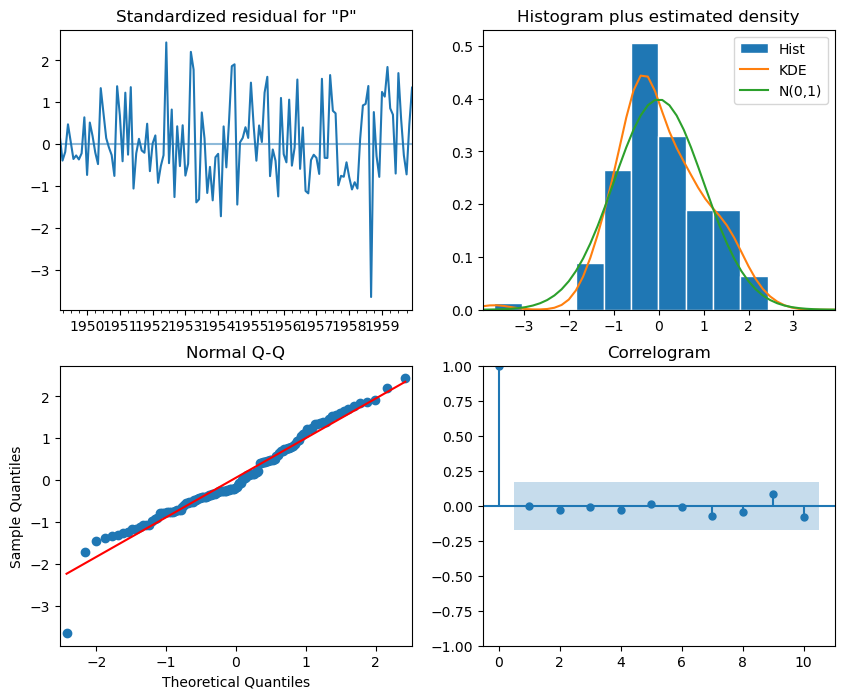

In [16]:
ARIMA_model = SARIMAX(df_train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
print(ARIMA_model_fit.summary())
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

Minimum p-value: 0.01 < 0.05
The residuals are correlated.  Not good.


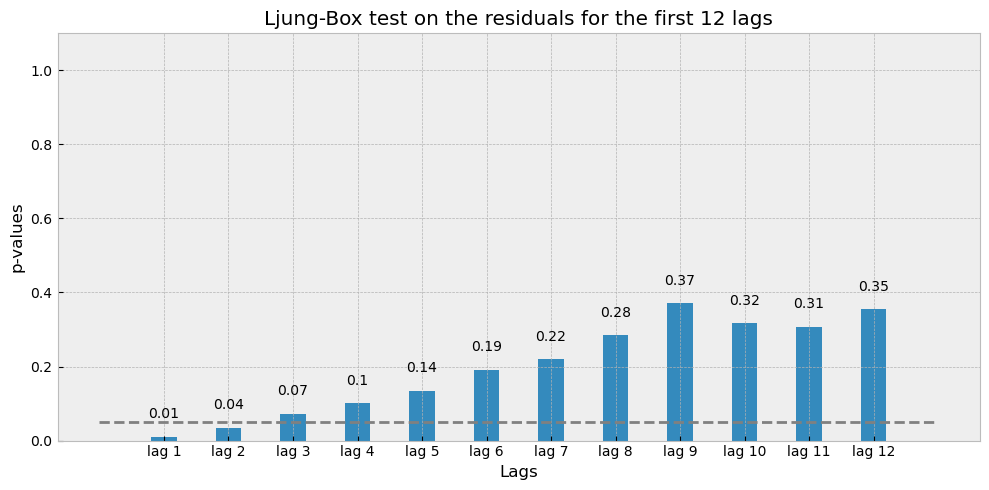

In [17]:
tt.ljungbox(np.array(ARIMA_model_fit.resid), lags=12)

In [18]:
ARIMA_model_fit.predict(12)

1950-01-01    132.701011
1950-02-01    120.398567
1950-03-01    138.950398
1950-04-01    137.119775
1950-05-01    129.945164
                 ...    
1959-08-01    552.914329
1959-09-01    465.749377
1959-10-01    414.402402
1959-11-01    357.207320
1959-12-01    391.204192
Freq: MS, Name: predicted_mean, Length: 120, dtype: float64

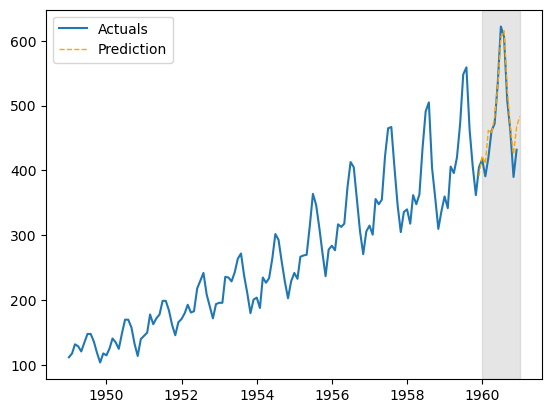

In [19]:
plt.plot(df['Passengers'], label='Actuals')
plt.plot(ARIMA_model_fit.predict(start='1959-12-01', end='1961-01-01'), 
    label='Prediction', ls='--', lw='1', color='orange')
plt.axvspan('1960-01-01', '1961-01-01', color='#808080', alpha=0.2)
plt.legend();

## SARIMA (p,d,q)(P,D,Q)<sub>m</sub>  
### Determine level of differencing: 
* d = 0  D = 1 
* d = 1  D = 1

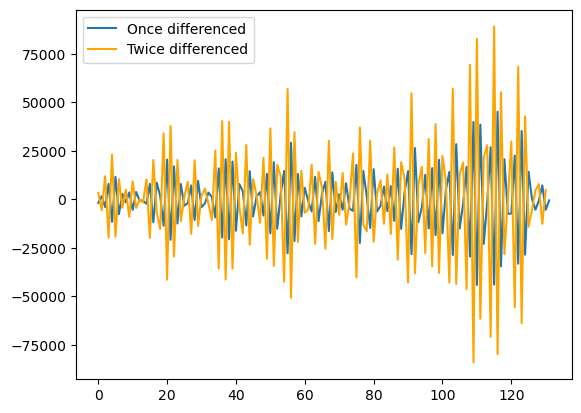

In [20]:
plt.plot(np.diff(df['Passengers'], n=12), label='Once differenced')
plt.plot(np.diff(np.diff(df['Passengers'], n=1), n=12), color='orange', label='Twice differenced')
plt.legend()

In [21]:
tt.adf_v2(df['Passengers'], diff=12)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=12

Test Statistic                -1.634342e+01
p-value                        2.980504e-29
#Lags Used                     1.300000e+01
Number of Observations Used    1.180000e+02
Critical Value (1%)           -3.487022e+00
Critical Value (5%)           -2.886363e+00
Critical Value (10%)          -2.580009e+00
dtype: float64

The time series is stationary.


### d = 0   D = 1

In [22]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))
SARIMA_order_list

df_train = df[:-12]

d = 0
D = 1
s = 12

In [23]:
tt.optimize_SARIMA(df_train['Passengers'], SARIMA_order_list, d, D, s=12)

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 0, 1, 2)",903.465891
1,"(2, 0, 2, 1)",904.373998
2,"(1, 1, 1, 2)",904.482021
3,"(2, 0, 2, 2)",905.137420
4,"(2, 1, 1, 2)",905.271021
...,...,...
248,"(0, 0, 1, 0)",1110.241607
249,"(0, 0, 0, 3)",1128.638123
250,"(0, 0, 0, 2)",1128.851859
251,"(0, 0, 0, 1)",1157.168128


                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -445.733
Date:                                 Sat, 15 Oct 2022   AIC                            903.466
Time:                                         09:47:37   BIC                            920.191
Sample:                                     01-01-1949   HQIC                           910.258
                                          - 12-01-1959                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6665      0.081      8.266      0.000       0.508       0

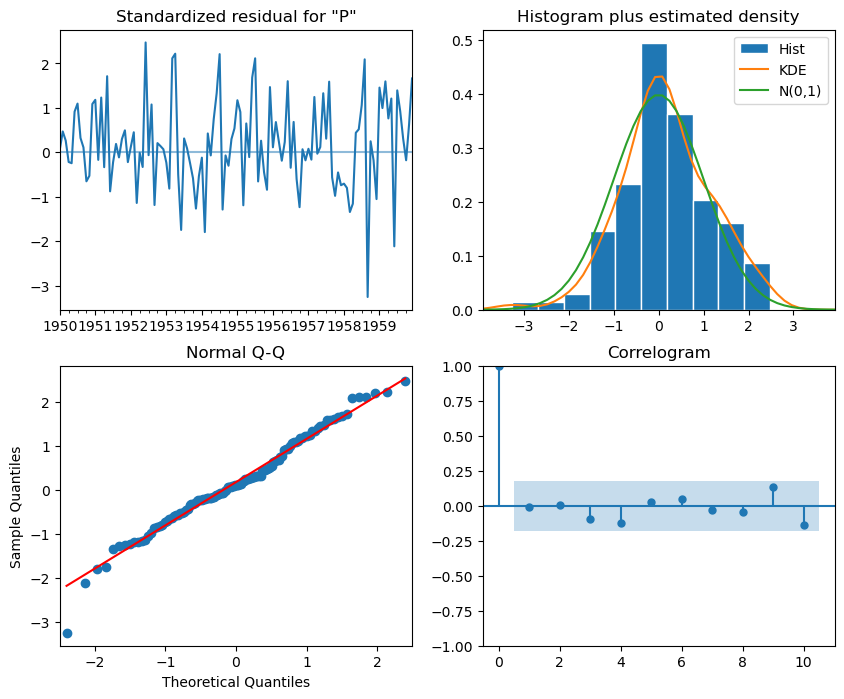

In [24]:
SARIMA_model = SARIMAX(df_train, order=(2,0,0), seasonal_order=(1,1,2, 12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
print(SARIMA_model_fit.summary())
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

Minimum p-value: 0.00 < 0.05
The residuals are correlated.  Not good.


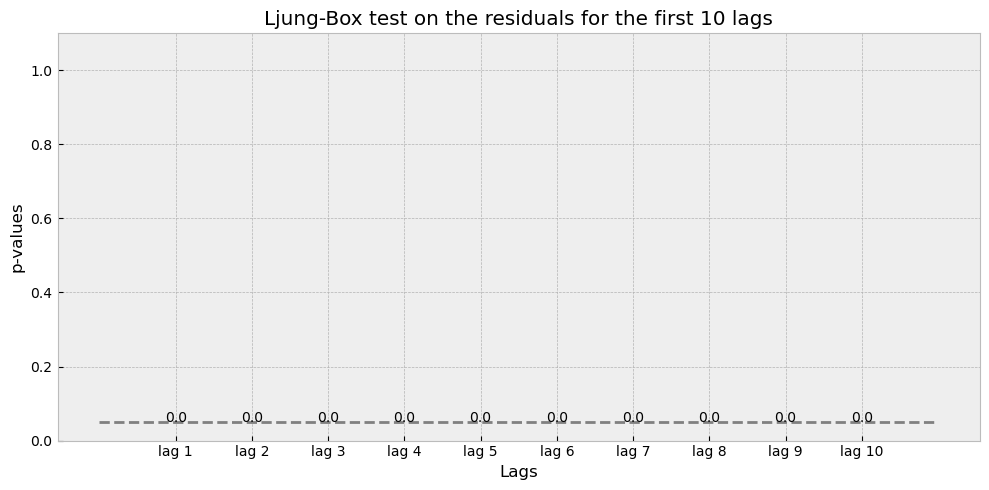

In [25]:
tt.ljungbox(SARIMA_model_fit.resid)

### Update dataset with newer datapoints 
#### Keep coefficients but add new datapoints 

In [26]:
SARIMA_model_fit_updated = SARIMA_model_fit.append(df[-12:])

In [27]:
SARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -445.733
Date:                                 Sat, 15 Oct 2022   AIC                            903.466
Time:                                         09:47:38   BIC                            920.191
Sample:                                     01-01-1949   HQIC                           910.258
                                          - 12-01-1959                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6665      0.081      8.266      0.000       0.508       0.825
ar.L2          0.2792      0.088      3.180      0.001       0.107       0.451
ar.S.L12       0.9984      0.100      9.957      0.000       0.802       1.195
ma.S.L12      -1.3237      1.189     -1.113      0.266      -3.655       1.007
ma.S.L24       0.3515      0.351      1.002      0.316      -0.336       1.039
sigma2        82.9497     94.237      0.880      0.379    -101.751     267.650
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.49
Prob(Q):                              0.94   Prob(JB):                         0.47
Heteroskedasticity (H):               1.56   Skew:                            -0.11
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
SARIMA_model_fit_updated.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                              Passengers   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -507.960
Date:                                 Sat, 15 Oct 2022   AIC                           1027.920
Time:                                         09:47:38   BIC                           1045.217
Sample:                                     01-01-1949   HQIC                          1034.949
                                          - 12-01-1960                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6665      0.081      8.266      0.000       0.508       0.825
ar.L2          0.2792      0.088      3.180      0.001       0.107       0.451
ar.S.L12       0.9984      0.100      9.957      0.000       0.802       1.195
ma.S.L12      -1.3237      1.189     -1.113      0.266      -3.655       1.007
ma.S.L24       0.3515      0.351      1.002      0.316      -0.336       1.039
sigma2        82.9497     94.237      0.880      0.379    -101.751     267.650
===================================================================================
Ljung-Box (L1) (Q):                   1.92   Jarque-Bera (JB):                26.37
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               2.68   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Parameters and standard errors were estimated using a different dataset and were then applied to this dataset. Covariance matrix calculated using the outer product of gradients (complex-step).
"""

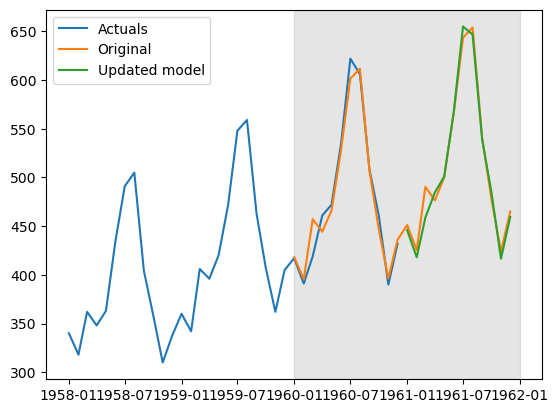

In [29]:
plt.plot(df[-36:]['Passengers'], label='Actuals')
plt.plot(SARIMA_model_fit.forecast(24), label='Original')  
plt.plot(SARIMA_model_fit_updated.forecast(12), label='Updated model')
plt.axvspan('1960-01-01', '1962-01-01', color='#808080', alpha=0.2)
plt.legend();

In [30]:
SARIMA_model_fit_updated.data.predict_dates

DatetimeIndex(['1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01',
               '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [31]:
SARIMA_model_fit.data.predict_dates

DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01',
               '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01',
               '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [32]:
SARIMA_model_fit_updated.fittedvalues

1949-01-01      0.000000
1949-02-01      0.104809
1949-03-01      0.212397
1949-04-01      0.329091
1949-05-01      0.439154
                 ...    
1960-08-01    626.958602
1960-09-01    508.399304
1960-10-01    446.608702
1960-11-01    405.979189
1960-12-01    435.681120
Freq: MS, Length: 144, dtype: float64

In [33]:
SARIMA_model_fit_updated.data.endog

array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
       126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
       178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
       181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
       229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
       264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
       364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413,
       405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467,
       404, 347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505, 404,
       359, 310, 337, 360, 342, 406, 396, 420, 472, 548, 559, 463, 407,
       362, 405, 417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390,
       432])

--- -
### Difference twice: d=1 and D=1


In [34]:
tt.adf_v2(df['Passengers'].diff(1)[1:], diff=12)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=12

Test Statistic                -1.762486e+01
p-value                        3.823047e-30
#Lags Used                     1.300000e+01
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64

The time series is stationary.


In [35]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))
SARIMA_order_list

df_train = df[:-12]['Passengers']

d = 1
D = 1
s = 12

In [36]:
tt.optimize_SARIMA(df_train, SARIMA_order_list, d, D, s=12)

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.237231
1,"(2, 1, 2, 1)",893.779967
2,"(2, 1, 1, 3)",894.082348
3,"(1, 0, 1, 2)",894.283677
4,"(0, 1, 1, 2)",894.990629
...,...,...
250,"(0, 0, 2, 0)",906.940147
251,"(3, 2, 0, 3)",907.181875
252,"(0, 0, 3, 2)",907.451487
253,"(0, 0, 3, 0)",908.742583


                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -439.119
Date:                                 Sat, 15 Oct 2022   AIC                            892.237
Time:                                         10:06:19   BIC                            911.691
Sample:                                     01-01-1949   HQIC                           900.137
                                          - 12-01-1959                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2664      0.085    -14.962      0.000      -1.432      -1

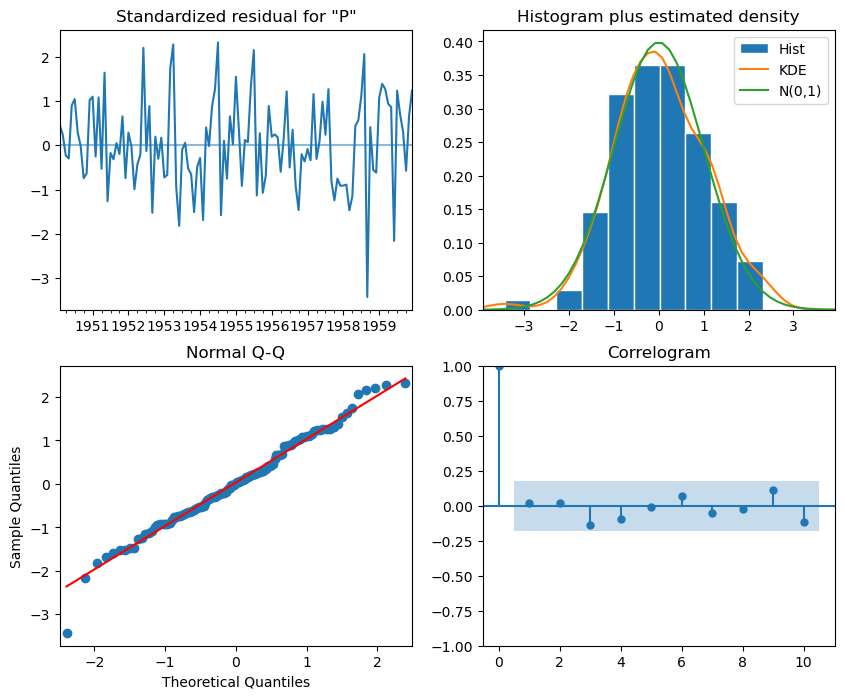

In [37]:
SARIMA_model = SARIMAX(df[:-12]['Passengers'], order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
print(SARIMA_model_fit.summary())
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

Minimum p-value: 0.35 > 0.05
The residuals are independent and not correlated.  Like white noise!


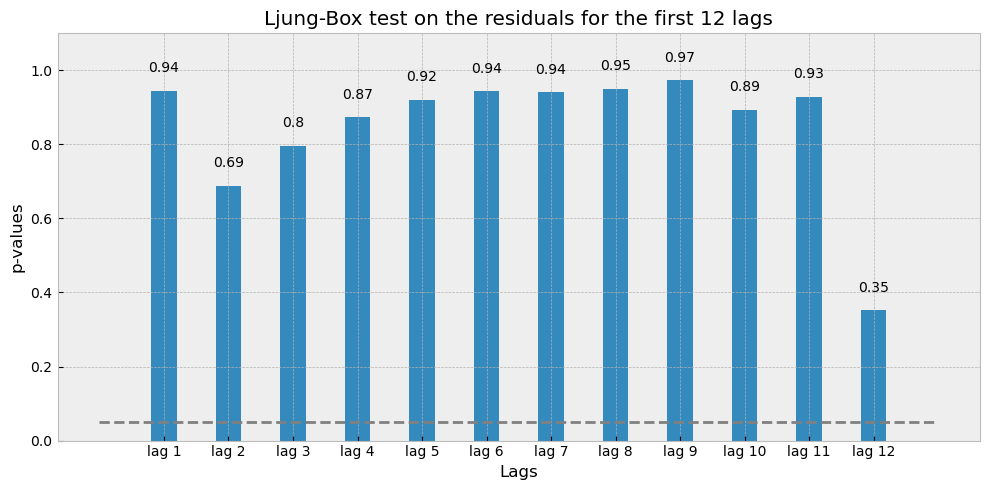

In [38]:
tt.ljungbox(SARIMA_model_fit.resid, lags=12)

### Compare model performance (MAPE) 
* Naive model 
* ARIMA(11,2,3) 
* SARIMA(2,1,1)(1,1,2,12)

In [39]:
index_naive_seasonal = df[-12:].index
df_naive_seasonal = df[-24:-12]
df_naive_seasonal.index = index_naive_seasonal
df_arima = pd.DataFrame(ARIMA_model_fit.forecast(12))
df_sarima = pd.DataFrame(SARIMA_model_fit.forecast(12))
results = pd.concat([df, df_naive_seasonal, df_arima, df_sarima], axis=1)
results.columns = ['actuals', 'naive', 'arima', 'sarima']
results

,actuals,naive,arima,sarima
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,NaN,NaN,NaN
1949-03-01,132,NaN,NaN,NaN
1949-04-01,129,NaN,NaN,NaN
1949-05-01,121,NaN,NaN,NaN
...,...,...,...,...
1960-08-01,606,559.0,615.486826,624.622518
1960-09-01,508,463.0,525.630060,520.181662
1960-10-01,461,407.0,467.118228,462.859709
1960-11-01,390,362.0,425.081774,412.731654


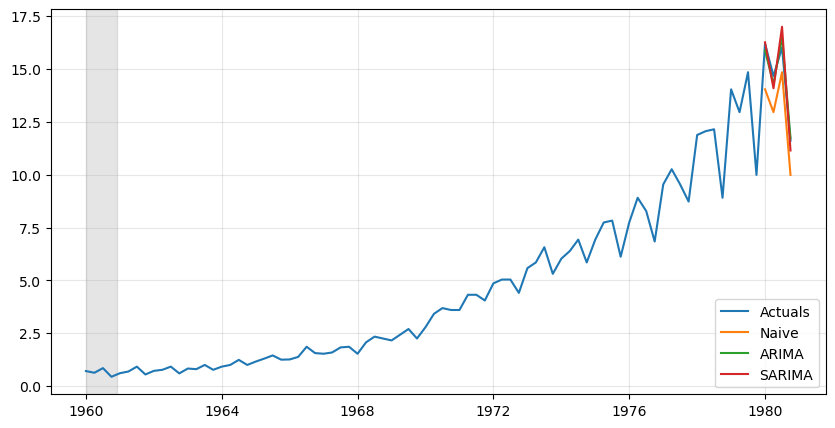

In [75]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(results.loc['1956':]['actuals'], label='Actuals')
ax.plot(results['naive'], label='Naive')
ax.plot(results['arima'], label='ARIMA')
ax.plot(results['sarima'], label='SARIMA')
ax.axvspan(xmin='1960-01', xmax='1960-12', color='#808080', alpha=0.2)
ax.legend()
ax.grid(True, alpha=0.3)

In [41]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [73]:
mape_naive_seasonal = mape(results.actuals, results.naive)
mape_arima = mape(results.actuals, results.arima)
mape_sarima = mape(results.actuals, results.sarima)

x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_arima, mape_sarima]

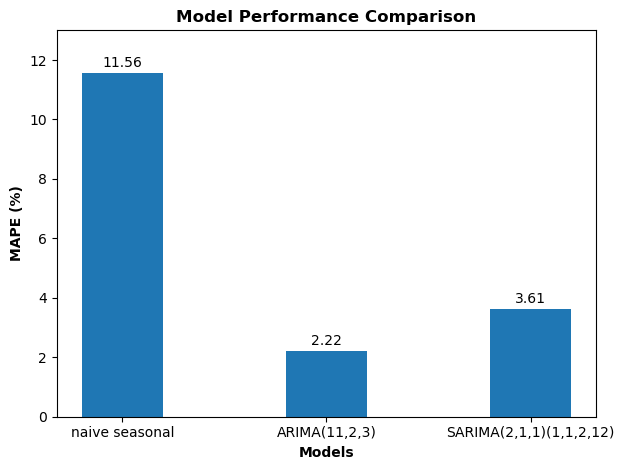

In [74]:
tt.plot_mapes(x, y, height=13)

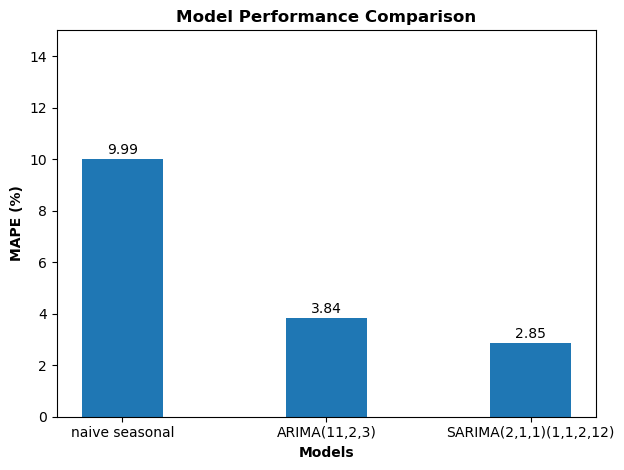

In [43]:
fig, ax = plt.subplots()
ax.bar(x, y, width=0.4)
ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=12)
ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('MAPE (%)', fontweight='bold')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.2, s=str(round(value, 2)), ha='center')

plt.tight_layout()

# Exercise: Johnson & Johnson

In [44]:
jj = omd.from_sqlite('select * from johnson_johnson', str(path / 'Datasets'))
jj['date'] = pd.to_datetime(jj['date'])
jj['date'] = jj['date'].dt.date
jj.set_index('date', inplace=True)

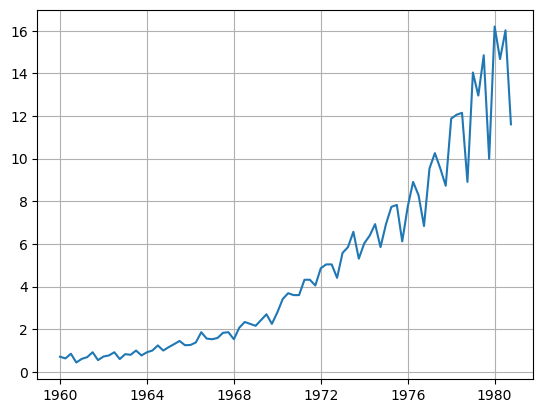

In [45]:
plt.plot(jj.data)
plt.grid(True)

### Look for trend and seasonality 
* `trend`: Yes 
* `seasonality`: Yes

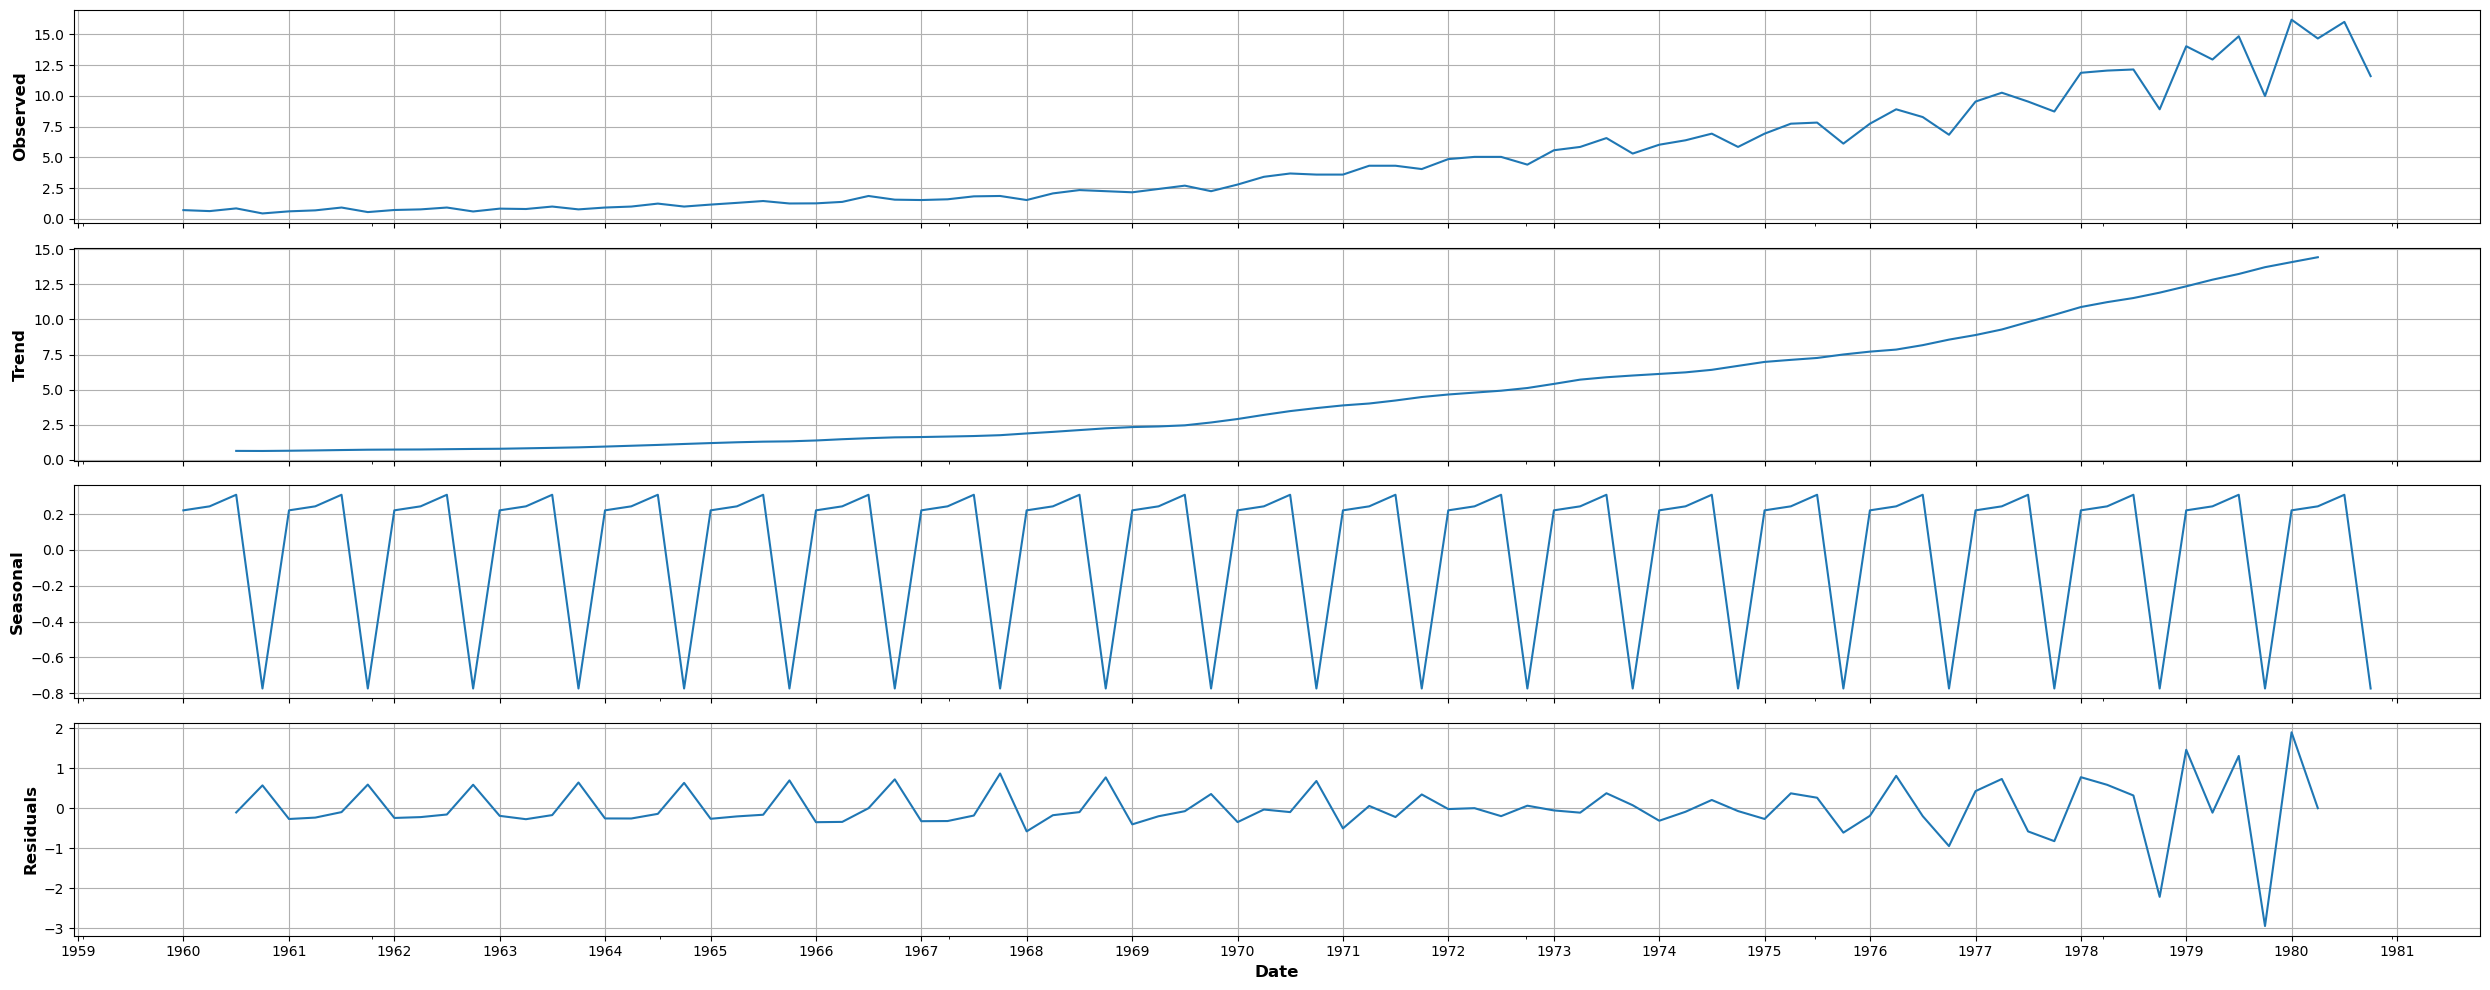

In [46]:
tt.seasonal_decomp(dat=jj['data'], period=4)

### Stationarity 
d = 2

In [47]:
tt.adf_v2(jj['data'])

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=0

Test Statistic                  2.742017
p-value                         1.000000
#Lags Used                     11.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

The time series is not stationary.


In [48]:
tt.adf_v2(jj['data'], diff=1)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=1

Test Statistic                 -0.407410
p-value                         0.908854
#Lags Used                     10.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

The time series is not stationary.


In [49]:
tt.adf_v2(jj['data'], diff=2)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=2

Test Statistic                 -3.585163
p-value                         0.006051
#Lags Used                      9.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

The time series is stationary.


Differenced?  d=2



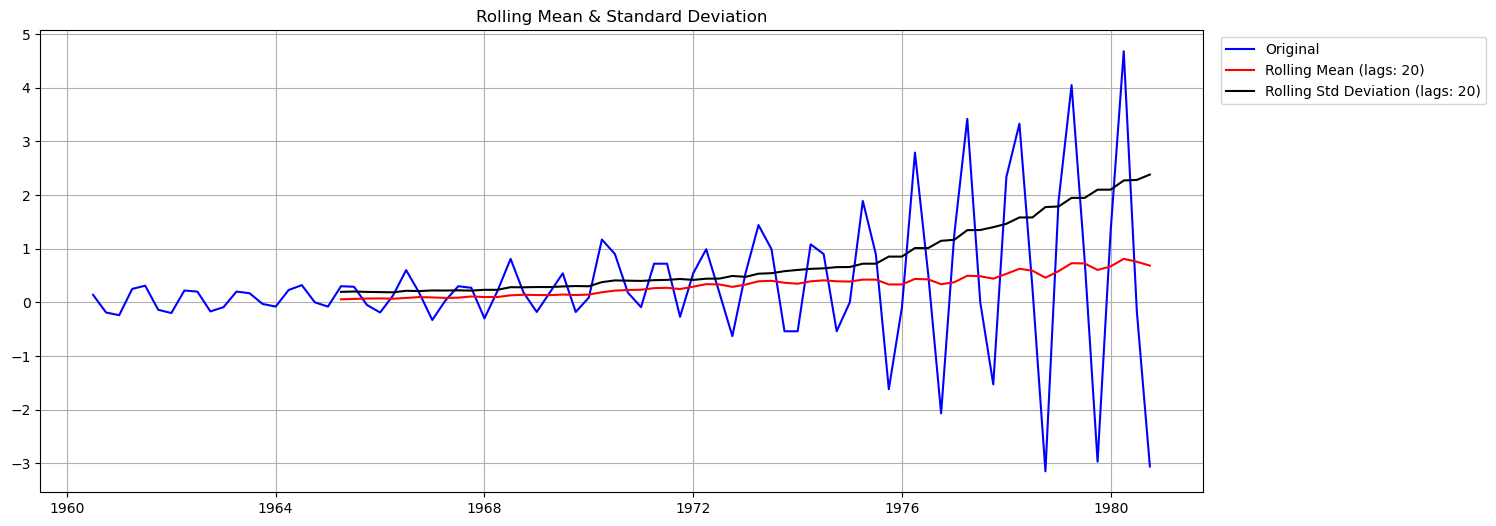

In [50]:
tt.plot_for_stationary(jj['data'], diff=2)

### ARIMA (p,d,q)

In [51]:
ps = range(0, 5, 1)
qs = range(0,5, 1)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 4

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [52]:
ARIMA_order_list 

[(0, 0, 0, 0),
 (0, 1, 0, 0),
 (0, 2, 0, 0),
 (0, 3, 0, 0),
 (0, 4, 0, 0),
 (1, 0, 0, 0),
 (1, 1, 0, 0),
 (1, 2, 0, 0),
 (1, 3, 0, 0),
 (1, 4, 0, 0),
 (2, 0, 0, 0),
 (2, 1, 0, 0),
 (2, 2, 0, 0),
 (2, 3, 0, 0),
 (2, 4, 0, 0),
 (3, 0, 0, 0),
 (3, 1, 0, 0),
 (3, 2, 0, 0),
 (3, 3, 0, 0),
 (3, 4, 0, 0),
 (4, 0, 0, 0),
 (4, 1, 0, 0),
 (4, 2, 0, 0),
 (4, 3, 0, 0),
 (4, 4, 0, 0)]

In [53]:
jj_train = jj[:-4]

In [54]:
tt.optimize_SARIMA(jj_train['data'], ARIMA_order_list, d, D, s=s)

  0%|          | 0/25 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 4, 0, 0)",112.374402
1,"(4, 4, 0, 0)",112.438770
2,"(4, 1, 0, 0)",114.496645
3,"(3, 3, 0, 0)",115.273694
4,"(4, 0, 0, 0)",115.528652
5,"(3, 1, 0, 0)",115.624980
6,"(3, 2, 0, 0)",115.672007
7,"(4, 2, 0, 0)",115.984299
8,"(4, 3, 0, 0)",119.658268
9,"(3, 0, 0, 0)",154.430625


                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 4)   Log Likelihood                 -48.187
Date:                Sat, 15 Oct 2022   AIC                            112.374
Time:                        10:06:27   BIC                            131.228
Sample:                             0   HQIC                           119.922
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0163      0.039    -26.110      0.000      -1.093      -0.940
ar.L2         -0.9955      0.048    -20.719      0.000      -1.090      -0.901
ar.L3         -0.9662      0.031    -31.453      0.0

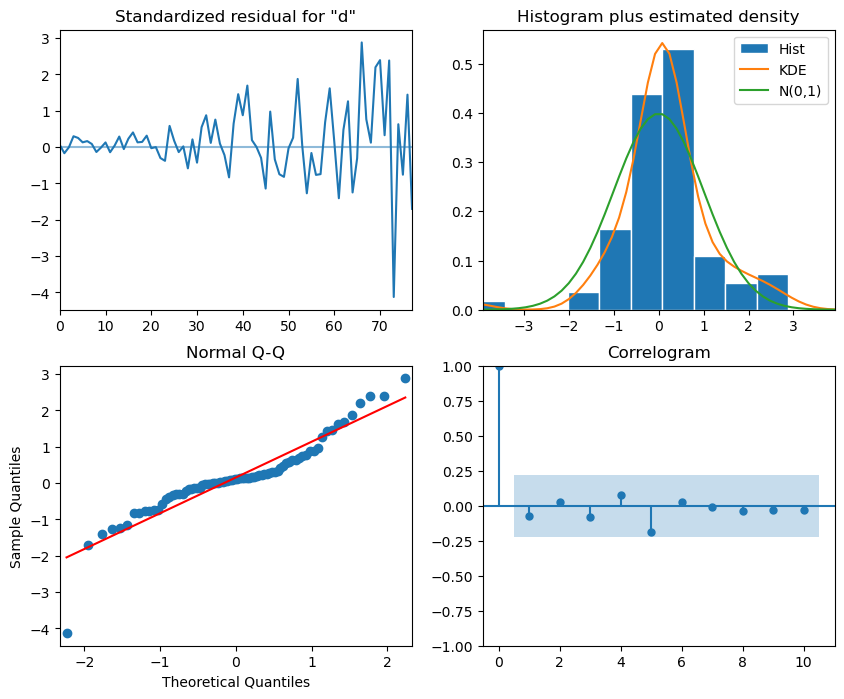

In [55]:
ARIMA_model = SARIMAX(jj_train, order=(3,d,4), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
print(ARIMA_model_fit.summary())
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

## SARIMA (p,d,q)(P,D,Q)<sub>m</sub>  
### Determine level of differencing: 
* d = 0  D = 1 

In [56]:
tt.adf_v2(jj['data'], diff=4)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=4

Test Statistic                -5.694684e+00
p-value                        7.923916e-07
#Lags Used                     1.200000e+01
Number of Observations Used    6.700000e+01
Critical Value (1%)           -3.531955e+00
Critical Value (5%)           -2.905755e+00
Critical Value (10%)          -2.590357e+00
dtype: float64

The time series is stationary.


In [57]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))
SARIMA_order_list

d = 0
D = 1
s = 4

In [58]:
SARIMA_order_list

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 1, 3),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 1, 2, 3),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 3, 2),
 (0, 1, 3, 3),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 1, 3),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (0, 2, 2, 3),
 (0, 2, 3, 0),
 (0, 2, 3, 1),
 (0, 2, 3, 2),
 (0, 2, 3, 3),
 (0, 3, 0, 0),
 (0, 3, 0, 1),
 (0, 3, 0, 2),
 (0, 3, 0, 3),
 (0, 3, 1, 0),
 (0, 3, 1, 1),
 (0, 3, 1, 2),
 (0, 3, 1, 3),
 (0, 3, 2, 0),
 (0, 3, 2, 1),
 (0, 3, 2, 2),
 (0, 3, 2, 3),
 (0, 3, 3, 0),
 (0, 3, 3, 1),
 (0, 3, 3, 2),
 (0, 3, 3, 3),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 0,

In [59]:
tt.optimize_SARIMA(jj_train, SARIMA_order_list, d, D, s=s)

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 2, 0, 0)",94.492056
1,"(2, 3, 0, 0)",94.663099
2,"(3, 3, 3, 1)",95.036305
3,"(3, 2, 0, 0)",95.103382
4,"(2, 3, 3, 1)",95.971832
...,...,...
251,"(0, 1, 0, 1)",146.712283
252,"(0, 0, 0, 2)",150.946452
253,"(0, 0, 0, 1)",164.363913
254,"(0, 1, 0, 0)",175.098492


                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   80
Model:             SARIMAX(2, 0, 2)x(0, 1, [], 4)   Log Likelihood                 -42.246
Date:                            Sat, 15 Oct 2022   AIC                             94.492
Time:                                    10:09:30   BIC                            106.146
Sample:                                         0   HQIC                            99.149
                                             - 80                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0408      0.200      0.203      0.839      -0.352       0.433
ar.L2          0.9457      0.192   

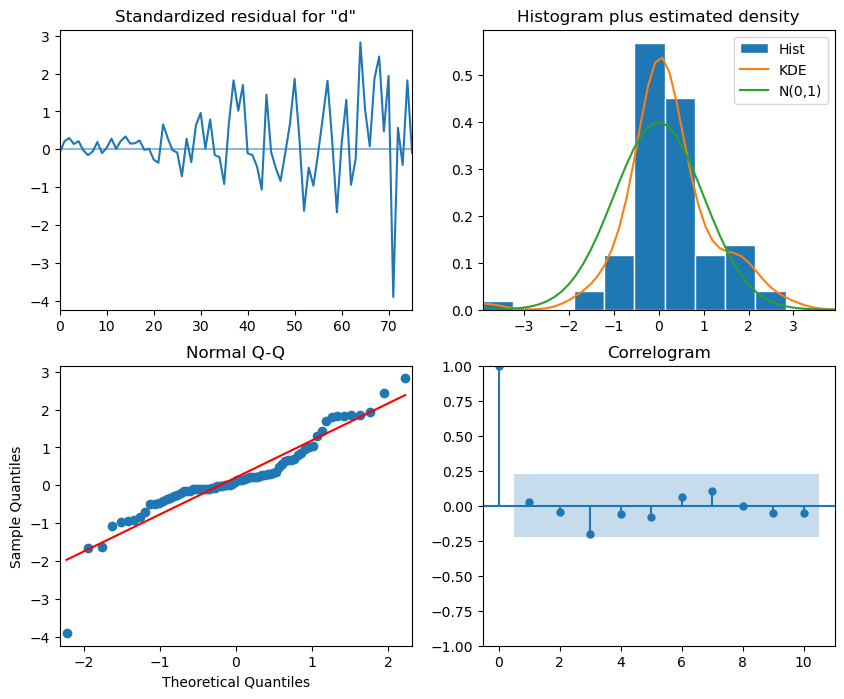

In [60]:
SARIMA_model = SARIMAX(jj_train, order=(2,d,2), seasonal_order=(0,D,0,s), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
print(SARIMA_model_fit.summary())
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

Minimum p-value: 0.39 > 0.05
The residuals are independent and not correlated.  Like white noise!


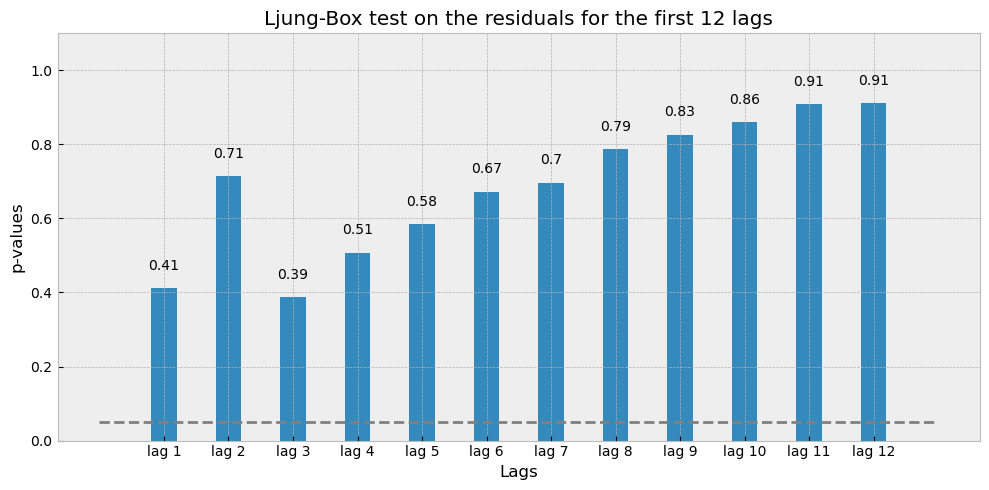

In [61]:
tt.ljungbox(SARIMA_model_fit.resid, lags=12)

### Compare model performance (MAPE)  
* Naive model 
* ARIMA(3,2,2) 
* SARIMA(1,0,2)(0,2,0,4)

In [62]:
index_naive_seasonal = jj[-4:].index
jj_naive_seasonal = jj[-8:-4]
jj_naive_seasonal.index = index_naive_seasonal
jj_arima = pd.DataFrame(ARIMA_model_fit.forecast(4))
jj_arima.index = index_naive_seasonal
jj_sarima = pd.DataFrame(SARIMA_model_fit.forecast(4))
jj_sarima.index = index_naive_seasonal
results = pd.concat([jj, jj_naive_seasonal, jj_arima, jj_sarima], axis=1)
results.columns = ['actuals', 'naive', 'arima', 'sarima']
results.tail(14)

,actuals,naive,arima,sarima
date,,,,
1977-07-02,9.540000,NaN,NaN,NaN
1977-10-01,8.729999,NaN,NaN,NaN
1978-01-01,11.880000,NaN,NaN,NaN
1978-04-02,12.060000,NaN,NaN,NaN
1978-07-02,12.150000,NaN,NaN,NaN
1978-10-01,8.910000,NaN,NaN,NaN
1979-01-01,14.040000,NaN,NaN,NaN
1979-04-02,12.960000,NaN,NaN,NaN
1979-07-02,14.850000,NaN,NaN,NaN


In [63]:
results.index = pd.to_datetime(results.index)
results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 1960-01-01 to 1980-10-01
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   actuals  84 non-null     float64
 1   naive    4 non-null      float64
 2   arima    4 non-null      float64
 3   sarima   4 non-null      float64
dtypes: float64(4)
memory usage: 3.3 KB


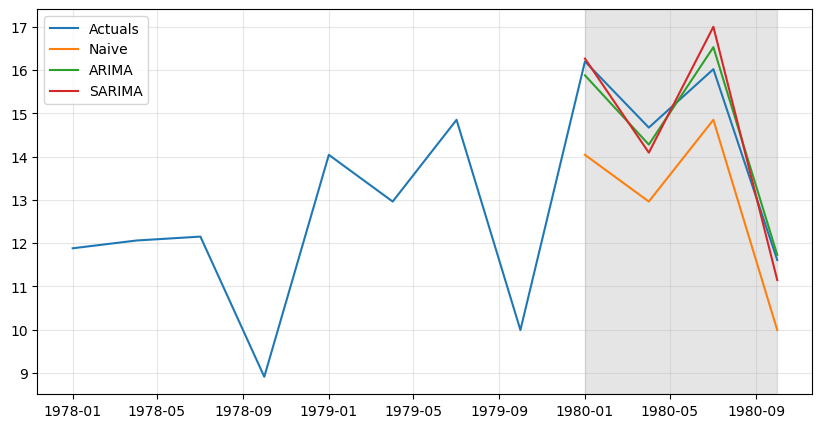

In [64]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(results.loc['1978':]['actuals'], label='Actuals')
ax.plot(results['naive'], label='Naive')
ax.plot(results['arima'], label='ARIMA')
ax.plot(results['sarima'], label='SARIMA')
ax.axvspan(xmin='1980-01', xmax='1980-10', color='#808080', alpha=0.2)
ax.legend()
ax.grid(True, alpha=0.3)

In [65]:
mape_naive_seasonal = mape(results.actuals, results.naive)
mape_arima = mape(results.actuals, results.arima)
mape_sarima = mape(results.actuals, results.sarima)

x = ['naive seasonal', 'ARIMA(3,2,4)', 'SARIMA(2,0,2)(0,1,0,4)']
y = [mape_naive_seasonal, mape_arima, mape_sarima]

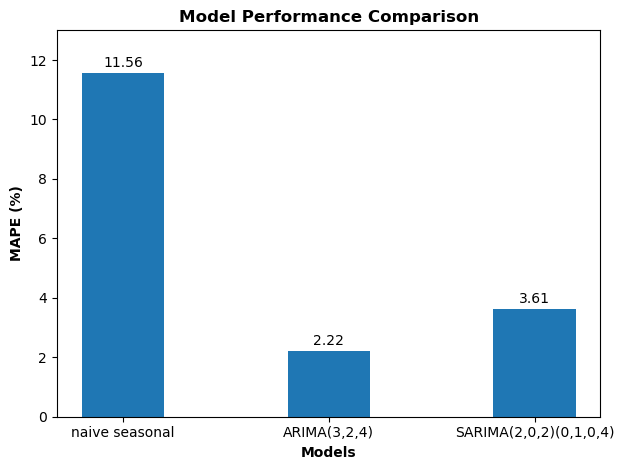

In [71]:
tt.plot_mapes(x, y, height=13)